In [5]:
import akshare as ak
import baostock as bs
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tushare as ts

In [13]:
def fetch_data_baostock(stock_code, ndays = 365):
    lg = bs.login()
    s_date = (datetime.datetime.now() - datetime.timedelta(days = 365)).strftime('%Y-%m-%d')
    e_date = datetime.datetime.now().strftime('%Y-%m-%d')
    data_list = []
    rs = bs.query_history_k_data_plus('sz.300661', "date,code,open,high,low,close", start_date=s_date, end_date=e_date, frequency="d")
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    bs.logout()
    plt.plot(result.index, result.close.astype('float'), color = 'r')
    plt.show()
    return result

In [14]:
def booling_cal(data, vol_3 = 0.5, vol_5 = 1, vol_10 = 1.5, vol_20 = 2):
    result = data.copy(deep = True)
    result['close'] = result.close.astype('float')
    result['ma3'] = result.close.rolling(3).mean()
    result['vol3'] = result.close.rolling(3).std()
    result['b3_up'] = result.ma3 + vol_3 * result.vol3
    result['b3_down'] = result.ma3 - vol_3 * result.vol3
    result['ma5'] = result.close.rolling(5).mean()
    result['vol5'] = result.close.rolling(5).std()
    result['b5_up'] = result.ma5 + vol_5 * result.vol5
    result['b5_down'] = result.ma5 - vol_5 * result.vol5
    result['ma10'] = result.close.rolling(10).mean()
    result['vol10'] = result.close.rolling(10).std()
    result['b10_up'] = result.ma10 + vol_10 * result.vol10
    result['b10_down'] = result.ma10 - vol_10 * result.vol10
    result['ma20'] = result.close.rolling(20).mean()
    result['vol20'] = result.close.rolling(20).std()
    result['b20_up'] = result.ma20 + vol_20 * result.vol20
    result['b20_down'] = result.ma20 - vol_20 * result.vol20
    return result

In [15]:
def booling_plt(data, start_idx, end_idx, vol_3 = 0.5, vol_5 = 1, vol_10 = 1.5, show_3 = True, show_5 = True, show_10 = True, show_20 = True):
    plt_data = booling_cal(data, vol_3, vol_5, vol_10)
    plt.plot(plt_data.index[start_idx:end_idx], plt_data.close.astype('float')[start_idx:end_idx], color = 'r')
    # MA3
    if show_3:
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.ma3[start_idx:end_idx], color = 'b', alpha = 0.5)
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b3_up[start_idx:end_idx], color = 'b', alpha = 0.3, linestyle = 'dashed')
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b3_down[start_idx:end_idx], color = 'b', alpha = 0.3, linestyle = 'dashed')
    # MA5
    if show_5:
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.ma5[start_idx:end_idx], color = 'g', alpha = 0.5)
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b5_up[start_idx:end_idx], color = 'g', alpha = 0.3, linestyle = 'dashed')
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b5_down[start_idx:end_idx], color = 'g', alpha = 0.3, linestyle = 'dashed')
    # MA10
    if show_10:
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.ma10[start_idx:end_idx], color = 'y', alpha = 0.5)
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b10_up[start_idx:end_idx], color = 'y', alpha = 0.3, linestyle = 'dashed')
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b10_down[start_idx:end_idx], color = 'y', alpha = 0.3, linestyle = 'dashed')
    if show_20:
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.ma20[start_idx:end_idx], color = 'pink', alpha = 0.5)
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b20_up[start_idx:end_idx], color = 'pink', alpha = 0.3, linestyle = 'dashed')
        plt.plot(plt_data.index[start_idx:end_idx], plt_data.b20_down[start_idx:end_idx], color = 'pink', alpha = 0.3, linestyle = 'dashed')
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.title('3日线蓝，5日线绿，10日线黄，20日线粉')
    plt.show()
    return

In [109]:
class investor:
    def  __init__(self, m = 100000, s = 0, f = 0, lev = 0.1):
        self.money = self.initial = self.max_m = self.min_m = m
        self.stock = s
        self.future = f
        self.index = 0
        self.leverage = lev
        self.transaction = 0
        self.debt = 0
        
    # 投资信息
    def info(self):
        print('初始资金:' + str(self.money) + '。保证金率:' + str(self.leverage * 100) + '%。')

    
    # 股票买卖
    def buy_stock(self, price, number = 0):
        self.transaction += 1
        ## 0 代表尽可能做多
        if number == 0:
            self.stock += self.money // price
            self.money = self.money % price
        else:
            self.stock += number
            self.money -= price * number
        
    def sell_stock(self, price, number = 0):
        self.transaction += 1
        ## 0 代表平仓
        if number == 0:
            self.money += price * self.stock
            self.stock = 0
        else:
            self.money += price * number
            self.stock -= number
    
    # 期货买卖
    def buy_future(self, price, multiplier, number = 0):
        self.transaction += 1
        money_cost = price * multiplier * self.leverage
        ## 先平仓
        if self.future < 0:
            self.money += self.future * price * multiplier - self.debt
            self.future = 0
            self.debt = 0
            
        ## 0代表尽可能做多
        if number == 0:
            self.future += (self.money / 2) // money_cost
            self.debt += price * multiplier * (1 - leverage) * ((self.money / 2) // money_cost)
            self.money -=  (self.money / 2) // money_cost * money_cost
        else:
            if self.money < total_cost * number:
                return
            self.future += number
            self.debt += price * multiplier * (1 - leverage) * number
            self.money -= money_cost * number
            
    def sell_future(self, price, multiplier, number = 0):
        self.transaction += 1
        ## 0代表平仓，-1代表做空
        money_cost = price * multiplier * self.leverage
        if number == 0 or number == -1:
            self.money += self.future * price * multiplier - self.debt
            self.future = 0
            self.debt = 0
        else:
            self.future -= number
            self.money += money_cost * number
            self.debt -= price * multiplier * (1 - leverage) * number
            
        # 以现有资金为准，做空份数不超过现有资金偿还能力
        if number == -1:
            self.future -= (self.money / 2)  // money_cost
            self.debt -= price * multiplier * (1 - leverage) * ((self.money / 2) // money_cost)
            self.money += ((self.money / 2) // money_cost) * money_cost
            
        
    def daily_record(self, price,multiplier, report = False):
        total_cost = price * multiplier * self.leverage
        self.max_m = max(self.money+self.stock*price+self.future*total_cost, self.max_m)
        self.min_m = min(self.money+self.stock*price+self.future*total_cost, self.min_m)
        if report:
            print(str(self.index+10)+ '-Money:' + str(np.round(self.money, 2)) + ';Stock:' + str(self.stock) +
                  ';Future:' + str(self.future) + '; Current market value:' + str(np.round(self.money+self.stock*price+self.future*price*multiplier-self.debt, 2)))
        self.index += 1
        
    def final_report(self, price, multiplier, echo = False):
        if self.stock != 0:
            self.money += price * self.stock
            self.stock = 0
        if self.future != 0:
            total_cost = price * multiplier * self.leverage
            self.money += total_cost * self.future
            self.future = 0
        if echo:
            print('最终收益为：' + str(np.round((self.money/self.initial - 1)*100, 2)) +
                  '%，最大收益为：' + str(np.round((self.max_m/self.initial - 1)*100, 2)) + 
                  '%，最大损失为:' + str(np.round((self.min_m/self.initial - 1)*100, 2)) + '%。共进行' + str(self.transaction) + '笔交易')
        return ((self.money/self.initial - 1)*100, (self.max_m/self.initial - 1)*100, (self.min_m/self.initial - 1)*100)

# 目标个股：圣邦股份 300661 半导体板块

In [82]:
dat = result.copy(deep=True)
dat['close'] = result.close.astype('float')
dat['ma3'] = result.close.rolling(3).mean()
dat['vol3'] = result.close.rolling(3).std()
dat['b3_up'] = dat.ma3 + 0.5 * dat.vol3
dat['b3_down'] = dat.ma3 - 0.5 * dat.vol3
dat['ma5'] = result.close.rolling(5).mean()
dat['vol5'] = result.close.rolling(5).std()
dat['b5_up'] = dat.ma5 + 1 * dat.vol5
dat['b5_down'] = dat.ma5 - 1 * dat.vol5
dat['ma10'] = result.close.rolling(10).mean()
dat['vol10'] = result.close.rolling(10).std()
dat['b10_up'] = dat.ma10 + 1.5 * dat.vol10
dat['b10_down'] = dat.ma10 - 1.5 * dat.vol10

### 策略：收盘价大于等于MA5时买入，小于等于MA5时卖出
##### 细节：

+ 买入时按当日收盘价买入，每次买入一股

+ 卖出时按当日收盘价卖出，每次全部卖出

+ 结束时全部卖出

In [37]:
money = 0
stock = 0
for i in range(len(dat)):
    if not np.isnan(dat.ma5[i]):
        if float(dat.close[i]) >= dat.ma5[i]:
            money -= float(dat.close[i])
            stock += 1
        elif  (float(dat.close[i]) <= dat.ma5[i]) & stock != 0:
            money += float(dat.close[i]) * stock
            stock = 0
#    print('Money:' + str(money) + ';Stock:' + str(stock))
if stock != 0:
    money += float(dat.close[len(dat)-1]) * stock
    stock = 0
print('最终受益为：' + str(np.round(money, 2)))

最终受益为：-911.41


### 策略：连续三日收盘价大于等于MA5时买入，连续三日小于等于MA5时卖出

In [70]:
money = 0
stock = 0
flag = 0
for i in range(len(dat)):
    if not np.isnan(dat.ma5[i]):
        if float(dat.close[i]) >= dat.ma5[i]:
            if flag < 0:
                flag = 1
            else:
                flag += 1
            if flag == 3:
                money -= float(dat.close[i])
                stock += 1
                flag = 2
        elif  (float(dat.close[i]) <= dat.ma5[i]) & stock != 0:
            if flag > 0:
                flag = -1
            else:
                flag -= 1
            if flag == -3:
                money += float(dat.close[i]) * stock
                stock = 0
                flag = -2
#    print('Money:' + str(money) + ';Stock:' + str(stock))
if stock != 0:
    money += float(dat.close[len(dat)-1]) * stock
    stock = 0
print('最终受益为：' + str(np.round(money, 2)))

最终受益为：-383.23


### 策略：收盘价大于等于MA10时买入，小于等于MA10时卖出

In [38]:
money = 0
stock = 0
for i in range(len(dat)):
    if not np.isnan(dat.ma10[i]):
        if float(dat.close[i]) >= dat.ma10[i]:
            money -= float(dat.close[i])
            stock += 1
        elif  (float(dat.close[i]) <= dat.ma10[i]) & stock != 0:
            money += float(dat.close[i]) * stock
            stock = 0
#    print('Money:' + str(money) + ';Stock:' + str(stock))
if stock != 0:
    money += float(dat.close[len(dat)-1]) * stock
    stock = 0
print('最终受益为：' + str(np.round(money, 2)))

最终受益为：-727.47


### 策略：连续三日收盘价大于等于MA10时买入，连续三日小于等于MA10时卖出

In [72]:
money = 0
stock = 0
flag = 0
for i in range(len(dat)):
    if not np.isnan(dat.ma10[i]):
        if float(dat.close[i]) >= dat.ma10[i]:
            if flag < 0:
                flag = 1
            else:
                flag += 1
            if flag == 3:
                money -= float(dat.close[i])
                stock += 1
                flag = 2
        elif  (float(dat.close[i]) <= dat.ma10[i]) & stock != 0:
            if flag > 0:
                flag = -1
            else:
                flag -= 1
            if flag == -3:
                money += float(dat.close[i]) * stock
                stock = 0
                flag = -2
#    print('Money:' + str(money) + ';Stock:' + str(stock))
if stock != 0:
    money += float(dat.close[len(dat)-1]) * stock
    stock = 0
print('最终受益为：' + str(np.round(money, 2)))

最终受益为：-1260.07


### 策略：布林带(10, 1.5)
##### 细节：
+ 收盘价向上突破布林带上界时按当日收盘价买入1股，向下突破上界时全部卖出
+ 假设不允许做空，则收盘价向下突破下界时不操作，向上突破下界时买入1股

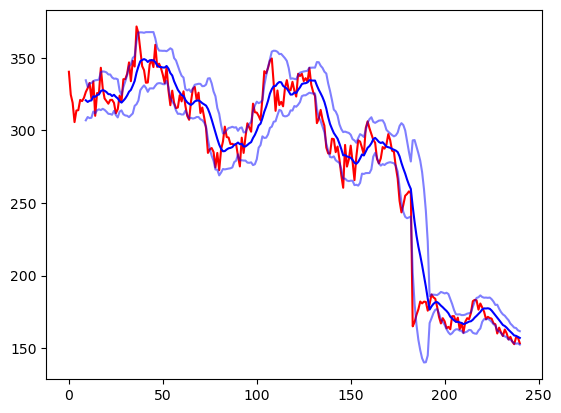

In [66]:
plt.plot(dat.index, dat.close, color = 'r')
plt.plot(dat.index, dat.ma10, color = 'b')
plt.plot(dat.index, dat.b10_up, color = 'b', alpha = 0.5)
plt.plot(dat.index, dat.b10_down, color = 'b', alpha = 0.5)

In [ ]:
money = 0
stock = 0
flag = 0
for i in range(len(dat)):
    if not np.isnan(dat.ma10[i]):
        # 向上突破上界
        if (dat.close[i] >= dat.b_up[i]) and (float(dat.close[i-1]) < dat.b_up[i-1]):
            money -= float(dat.close[i])
            stock += 1
        # 向上突破下界
        elif (dat.close[i] >= dat.b_down[i]) and (float(dat.close[i-1]) < dat.b_down[i-1]):
            money -= float(dat.close[i])
            stock += 1
        # 向下突破上界
        elif  (dat.close[i] <= dat.b_up[i]) and (float(dat.close[i-1]) > dat.b_up[i-1]) and stock != 0:
            money += float(dat.close[i]) * stock
            stock = 0
    print('Money:' + str(money) + ';Stock:' + str(stock))
if stock != 0:
    money += float(dat.close[len(dat)-1]) * stock
    stock = 0
print('最终受益为：' + str(np.round(money, 2)))

### 策略：布林带改进版
##### 细节：
+ 收盘价向上突破布林带(3, 0.5)上界的1.2倍时按当日收盘价买入1股，向下突破布林带(5, 1)上界且未突破布林带(5,1)下界时全部卖出
+ 假设不允许做空，则收盘价向下突破下界时不操作，向上突破布林带(10, 1.5)下界且未突破布林带(3, 0.5)上界时买入1股

##### 思路：
+ 股票震荡下跌，因而选取较为敏感的布林带上界和较不敏感的布林带下界来发送信号。同时由于波动较为剧烈，短期内直接冲破布林带（如由上界之上直接冲到下界之下）的不做买卖处理。

In [88]:
money = 0
stock = 0
max_money = 0
min_money = 0
for i in range(len(dat)):
    if not np.isnan(dat.ma10[i]):
        # 买信号
        ## 向上突破布林带(3, 0.5)上界的1.2倍
        if (dat.close[i] >= dat.b3_up[i]*1.2) and (dat.close[i-1] < dat.b3_up[i-1]):
            money -= dat.close[i]
            stock += 1
        ## 向上突破布林带(10,1.5)下界且没有突破(3,0.5)上界
        elif (dat.close[i] >= dat.b10_down[i]) and (dat.close[i-1] < dat.b10_down[i-1]) and (dat.close[i] < dat.b3_up[i]):
            money -= dat.close[i]
            stock += 1
        # 卖信号
        ## 向下突破(5,1)上界且没有突破(5,1)下界
        elif  (dat.close[i] <= dat.b5_up[i]) and (dat.close[i-1] > dat.b5_up[i-1]) and (dat.close[i] > dat.b5_down[i]) and stock != 0:
            money += dat.close[i] * stock
            stock = 0
#    print('Day ' + str(i) + '-Money:' + str(money) + ';Stock:' + str(stock))
        max_money = max(money+stock*dat.close[i], max_money)
        min_money = min(money+stock*dat.close[i], min_money)
if stock != 0:
    money += dat.close[len(dat)-1] * stock
    stock = 0
print('最终收益为：' + str(np.round(money, 2)) + '，最大收益为：' + str(np.round(max_money, 2)) + '，最大损失为:' + str(np.round(min_money, 2)))

最终收益为：-3.82，最大收益为：17.46，最大损失为:-5.04


### 测试其他股票

# 目标个股：韦尔股份 603501 半导体板块

login success!
logout success!


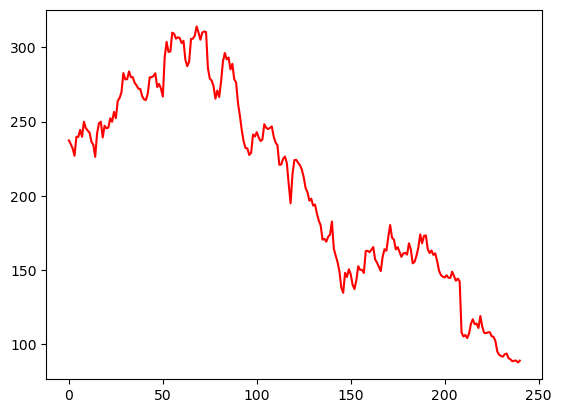

In [89]:
lg = bs.login()
s_date = (datetime.datetime.now() - datetime.timedelta(days = 365)).strftime('%Y-%m-%d')
e_date = datetime.datetime.now().strftime('%Y-%m-%d')
data_list = []
rs = bs.query_history_k_data_plus('sh.603501', "date,code,open,high,low,close", start_date=s_date, end_date=e_date, frequency="d")
while (rs.error_code == '0') & rs.next():
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
bs.logout()
plt.plot(result.index, result.close.astype('float'), color = 'r')

In [90]:
dat = result.copy(deep=True)
dat['close'] = result.close.astype('float')
dat['ma3'] = result.close.rolling(3).mean()
dat['vol3'] = result.close.rolling(3).std()
dat['b3_up'] = dat.ma3 + 0.5 * dat.vol3
dat['b3_down'] = dat.ma3 - 0.5 * dat.vol3
dat['ma5'] = result.close.rolling(5).mean()
dat['vol5'] = result.close.rolling(5).std()
dat['b5_up'] = dat.ma5 + 1 * dat.vol5
dat['b5_down'] = dat.ma5 - 1 * dat.vol5
dat['ma10'] = result.close.rolling(10).mean()
dat['vol10'] = result.close.rolling(10).std()
dat['b10_up'] = dat.ma10 + 1.5 * dat.vol10
dat['b10_down'] = dat.ma10 - 1.5 * dat.vol10
money = 0
stock = 0
max_money = 0
min_money = 0
for i in range(len(dat)):
    if not np.isnan(dat.ma10[i]):
        # 买信号
        ## 向上突破布林带(3, 0.5)上界的1.2倍
        if (dat.close[i] >= dat.b3_up[i]*1.2) and (dat.close[i-1] < dat.b3_up[i-1]):
            money -= dat.close[i]
            stock += 1
        ## 向上突破布林带(10,1.5)下界且没有突破(3,0.5)上界
        elif (dat.close[i] >= dat.b10_down[i]) and (dat.close[i-1] < dat.b10_down[i-1]) and (dat.close[i] < dat.b3_up[i]):
            money -= dat.close[i]
            stock += 1
        # 卖信号
        ## 向下突破(5,1)上界且没有突破(5,1)下界
        elif  (dat.close[i] <= dat.b5_up[i]) and (dat.close[i-1] > dat.b5_up[i-1]) and (dat.close[i] > dat.b5_down[i]) and stock != 0:
            money += dat.close[i] * stock
            stock = 0
#    print('Day ' + str(i) + '-Money:' + str(money) + ';Stock:' + str(stock))
        max_money = max(money+stock*dat.close[i], max_money)
        min_money = min(money+stock*dat.close[i], min_money)
if stock != 0:
    money += dat.close[len(dat)-1] * stock
    stock = 0
print('最终收益为：' + str(np.round(money, 2)) + '，最大收益为：' + str(np.round(max_money, 2)) + '，最大损失为:' + str(np.round(min_money, 2)))

最终收益为：-7.75，最大收益为：82.08，最大损失为:-23.75


# 沪深当月连续合约 （允许做空）

In [44]:
#ts.set_token('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
#pro = ts.pro_api()
#s_date = (datetime.datetime.now() - datetime.timedelta(days = 365)).strftime('%Y%m%d')
#e_date = datetime.datetime.now().strftime('%Y%m%d')
#df = pro.fut_daily(ts_code='IFL.CFX', start_date=s_date, end_date=e_date)
#df_a = df[['trade_date', 'open', 'high', 'low',  'close']]
#df_a.to_csv('IFLCFX.csv')
dat = pd.read_csv('IFLCFX.csv', index_col = 0)
dat = booling_cal(dat, 0.5, 1, 1.5, 2)

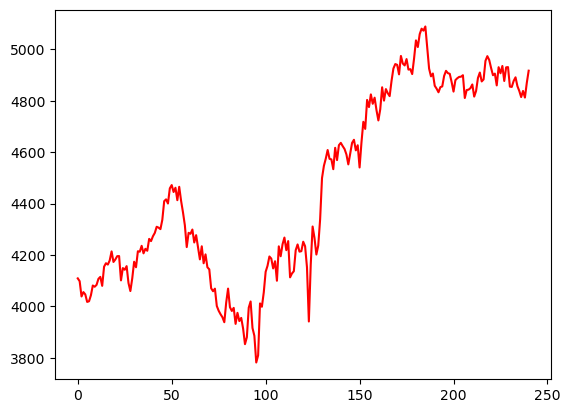

In [31]:
plt.plot(dat.index, dat.close.astype('float'), color = 'r')

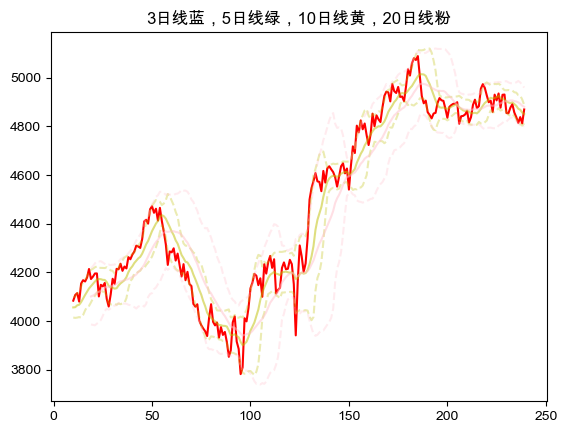

In [32]:
booling_plt(dat, 10, len(dat)-1, 0.5, 1, 1.5, False, False, True, True)

+ 初始资金100000
+ 前10天不操作
+ 向上突破布林带(3, 0.5)上界时先平仓，再尽可能买入
+ 向上突破布林带(10, 2)下界且未突破布林带(5, 1.2)上界时先平仓，再尽可能买入
+ 向下突破布林带(3, 0.5)上界且未突破布林带(3,0.5)下界时，先全部卖出平仓，再做空5份合约
+ 向下突破布林带(10, 1.5)时，先全部卖出平仓，再做空5份合约

In [34]:
test_i = investor(50000)
leverage = 0.1
multiplier = 300
for i in range(len(dat)):
    # 前十天不做处理
    if not np.isnan(dat.ma10[i]):
        
        # 买信号
        ## 向上突破布林带(3, 0.5)上界
        if (dat.close[i] >= dat.b3_up[i]) and (dat.close[i-1] < dat.b3_up[i-1]):
            test_i.buy_stock(dat.close[i])

        ## 向上突破布林带(10,2)下界且没有突破(5,1.2)上界
        elif (dat.close[i] >= dat.b10_down[i]) and (dat.close[i-1] < dat.b10_down[i-1]) and (dat.close[i] < dat.b5_up[i]):
            test_i.buy_stock(dat.close[i])
    
        # 卖信号
        ## 向下突破布林带(10,1.5)下界
        elif  (dat.close[i] <= dat.b10_down[i]) and (dat.close[i-1] > dat.b10_down[i-1]):
            test_i.sell_stock(dat.close[i])
            test_i.sell_stock(dat.close[i], 5)
            
        ## 向下突破(3,0.5)上界且没有突破(3,0.5)下界
        elif  (dat.close[i] <= dat.b3_up[i]) and (dat.close[i-1] > dat.b3_up[i-1]) and (dat.close[i] > dat.b3_down[i]):
            test_i.sell_stock(dat.close[i])
            test_i.sell_stock(dat.close[i], 5)  
        test_i.daily_record(dat.close[i], False)

test_i.final_report(dat.close[len(dat)-1], 300)

最终收益为：-8.74%，最大收益为：2.5%，最大损失为:-13.6%。共进行132笔交易


### 策略部分一：收盘价>MA5时买入，小于MA5时卖出

+ 买入时每次做多一份

+ 卖出时每次做空一份

+ 结束时平仓

### 策略部分二：冲破布林带（5,1）上界时买入，下界时卖出

+ 买入时每次按现有资金的一半尽量做多

+ 卖出时每次按现有资金的一半尽量做空

+ 结束时平仓

In [36]:
test_i = investor(500000, 0, 0, 0.1)
test_i.info()
# 前二十天不做处理
for i in range(20, len(dat)):    
    # 买信号
    ## 收盘价 > MA5
#    if dat.close[i] >= dat.ma5[i]:
#        test_i.buy_future(dat.close[i], 300, 1)
#        next
    ## 向上冲破布林带(20, 2)上界：
    if dat.close[i] >= dat.b20_up[i] and dat.close[i-1] < dat.b20_up[i-1]:
#        test_i.buy_future(dat.close[i], 300, 10)
        test_i.buy_future(dat.close[i], 300)
        next
    ## 向上冲破布林带(20, 2)下界：
    if dat.close[i] >= dat.b20_down[i] and dat.close[i-1] < dat.b20_down[i-1]:
#        test_i.buy_future(dat.close[i], 300, 10)
        test_i.buy_future(dat.close[i], 300)
        next    

    # 卖信号
    ## 收盘价 < MA5
#    if  dat.close[i] <= dat.ma5[i]:
#        test_i.sell_future(dat.close[i], 300, 1)
#        next
    ## 向下冲破布林带(20, 2)上界：
    if dat.close[i] <= dat.b20_up[i] and dat.close[i-1] > dat.b20_up[i-1]:
        test_i.sell_future(dat.close[i], 300, -1)
        next
    ## 向下冲破布林带(20, 2)下界：
    if dat.close[i] <= dat.b20_down[i] and dat.close[i-1] > dat.b20_down[i-1]:
        test_i.sell_future(dat.close[i], 300, -1)
        next
    test_i.daily_record(dat.close[i], 300, False)

test_i.final_report(dat.close[len(dat)-1], 300)

初始资金:500000。保证金率:10.0%。
最终收益为：10.14%，最大收益为：12.86%，最大损失为:-0.21%。共进行24笔交易


### 1分钟级别数据

In [19]:
dat_1 = ak.futures_zh_minute_sina(symbol="IF0", period="1")
dat_1.drop(['volume', 'hold'], axis = 1, inplace = True)
dat_1 = booling_cal(dat_1, 0.5, 1, 1.5, 2)

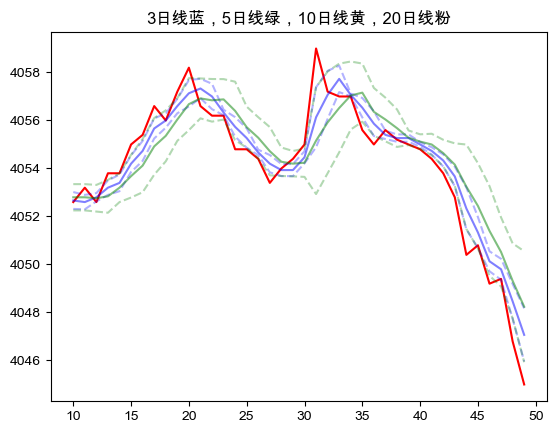

In [86]:
booling_plt(dat_1, 10, 50, 0.5, 1, 1.5, True, True, False, False)

In [ ]:
dat_1 = ak.futures_zh_minute_sina(symbol="IF0", period="1")
dat_1.drop(['volume', 'hold'], axis = 1, inplace = True)
max_profit = 0
max_idx = (0, 0)
for i in range(3, 31, 1):
    for j in np.arange(0.2, 3.1, 0.01):
        dat = dat_1.copy(deep = True)
        dat['close'] = dat.close.astype('float')
        dat['ma'] = dat.close.rolling(i).mean()
        dat['vol'] = dat.close.rolling(i).std()
        dat['b_up'] = dat.ma + j * dat.vol
        dat['b_down'] = dat.ma - j * dat.vol
        
        test_i = investor(500000, 0, 0, 0.1)
        #test_i.info()
        # 前三十天不做处理
        for k in range(30, len(dat)):    
            # 买信号
            ## 收盘价 > MA5
        #    if dat.close[i] >= dat.ma5[i]:
        #        test_i.buy_future(dat.close[i], 300, 1)
        #        next
            ## 向上冲破布林带(3, 0.5)上界：
            if dat.close[k] >= dat.b_up[k] and dat.close[k-1] < dat.b_up[k-1]:
        #        test_i.buy_future(dat.close[i], 300, 10)
                test_i.buy_future(dat.close[k], 300)
                next
            ## 向上冲破布林带(3, 0.5)下界：
            if dat.close[k] >= dat.b_down[k] and dat.close[k-1] < dat.b_down[k-1]:
        #        test_i.buy_future(dat.close[i], 300, 10)
                test_i.buy_future(dat.close[k], 300)
                next    

            # 卖信号
            ## 收盘价 < MA5
        #    if  dat.close[i] <= dat.ma5[i]:
        #        test_i.sell_future(dat.close[i], 300, 1)
        #        next
            ## 向下冲破布林带(3, 0.5)上界：
            if dat.close[k] <= dat.b_up[k] and dat.close[k-1] > dat.b_up[k-1]:
                test_i.sell_future(dat.close[k], 300, -1)
                next
            ## 向下冲破布林带(3, 0.5)下界：
            if dat.close[k] <= dat.b_down[k] and dat.close[k-1] > dat.b_down[k-1]:
                test_i.sell_future(dat.close[k], 300, -1)
                next
            test_i.daily_record(dat.close[k], 300, False)
        a,b,c = test_i.final_report(dat.close[len(dat)-1], 300)
        if a > max_profit:
            max_profit = a
            max_idx = (i,j)
print(np.round(max_profit, 2), max_idx)

### 5分钟级别数据

In [124]:
dat_5 = ak.futures_zh_minute_sina(symbol="IF0", period="5")
dat_5.drop(['volume', 'hold'], axis = 1, inplace = True)
max_profit = 0
max_idx = (0, 0)
for i in range(3, 31, 1):
    for j in np.arange(0.2, 3.1, 0.01):
        dat = dat_5.copy(deep = True)
        dat['close'] = dat.close.astype('float')
        dat['ma'] = dat.close.rolling(i).mean()
        dat['vol'] = dat.close.rolling(i).std()
        dat['b_up'] = dat.ma + j * dat.vol
        dat['b_down'] = dat.ma - j * dat.vol
        
        test_i = investor(500000, 0, 0, 0.1)
        #test_i.info()
        # 前三十天不做处理
        for k in range(30, len(dat)):    
            # 买信号
            ## 收盘价 > MA5
        #    if dat.close[i] >= dat.ma5[i]:
        #        test_i.buy_future(dat.close[i], 300, 1)
        #        next
            ## 向上冲破布林带(3, 0.5)上界：
            if dat.close[k] >= dat.b_up[k] and dat.close[k-1] < dat.b_up[k-1]:
        #        test_i.buy_future(dat.close[i], 300, 10)
                test_i.buy_future(dat.close[k], 300)
                next
            ## 向上冲破布林带(3, 0.5)下界：
            if dat.close[k] >= dat.b_down[k] and dat.close[k-1] < dat.b_down[k-1]:
        #        test_i.buy_future(dat.close[i], 300, 10)
                test_i.buy_future(dat.close[k], 300)
                next    

            # 卖信号
            ## 收盘价 < MA5
        #    if  dat.close[i] <= dat.ma5[i]:
        #        test_i.sell_future(dat.close[i], 300, 1)
        #        next
            ## 向下冲破布林带(3, 0.5)上界：
            if dat.close[k] <= dat.b_up[k] and dat.close[k-1] > dat.b_up[k-1]:
                test_i.sell_future(dat.close[k], 300, -1)
                next
            ## 向下冲破布林带(3, 0.5)下界：
            if dat.close[k] <= dat.b_down[k] and dat.close[k-1] > dat.b_down[k-1]:
                test_i.sell_future(dat.close[k], 300, -1)
                next
            test_i.daily_record(dat.close[k], 300, False)
        a,b,c = test_i.final_report(dat.close[len(dat)-1], 300)
        if a > max_profit:
            max_profit = a
            max_idx = (i,j)
print(np.round(max_profit, 2), max_idx)

KeyboardInterrupt: 

In [179]:
ts.set_token('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
pro = ts.pro_api()
s_date = (datetime.date(2019,1,1)).strftime('%Y-%m-%d') + ' 09:00:00'
e_date = datetime.date(2019,12,31).strftime('%Y-%m-%d') + ' 15:00:00'
ts.pro_bar('IFL.CFX', asset='FT', freq = '5min', start_date = s_date, end_date = e_date)

抱歉，您每天最多访问该接口10次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口4次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。
抱歉，您每分钟最多访问该接口4次，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。


OSError: ERROR.

In [178]:
ts.set_token('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
pro = ts.pro_api()
s_date = (datetime.datetime.now() - datetime.timedelta(days = 365)).strftime('%Y%m%d')
e_date = datetime.datetime.now().strftime('%Y%m%d')
pro.fut_daily(ts_code='IFL.CFX', start_date=s_date, end_date=e_date)

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,change2,vol,amount,oi,oi_chg
0,IFL.CFX,20220915,4068.8,4069.6,4075.0,4086.6,4005.8,4029.8,4022.40,-39.8,-47.20,52957.0,6.439958e+06,33911.0,None
1,IFL.CFX,20220914,4109.2,4115.8,4072.2,4096.0,4054.0,4068.8,4069.60,-47.0,-46.20,58786.0,7.187959e+06,57133.0,None
2,IFL.CFX,20220913,4098.2,4099.8,4102.0,4134.4,4101.8,4109.2,4115.80,9.4,16.00,58759.0,7.256998e+06,69978.0,None
3,IFL.CFX,20220909,4038.8,4041.0,4048.6,4106.8,4045.4,4098.2,4099.80,57.2,58.80,66685.0,8.168158e+06,84837.0,None
4,IFL.CFX,20220908,4055.8,4052.4,4065.0,4070.0,4036.6,4038.8,4041.00,-13.6,-11.40,49176.0,5.978668e+06,88287.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,IFL.CFX,20210923,4814.6,4811.8,4838.0,4878.2,4821.4,4838.4,4834.60,26.6,22.80,70537.0,1.025236e+07,87619.0,None
238,IFL.CFX,20210922,4838.4,4846.4,4777.8,4834.0,4767.4,4814.6,4811.80,-31.8,-34.60,79208.0,1.140880e+07,88491.0,None
239,IFL.CFX,20210917,4812.6,4820.0,4810.0,4843.2,4794.4,4838.4,4838.73,18.4,18.73,26001.0,3.761603e+06,0.0,None
240,IFL.CFX,20210916,4869.8,4859.4,4873.8,4886.6,4805.6,4812.6,4820.00,-46.8,-39.40,61240.0,8.899290e+06,33731.0,None
